# PREPARE ENVIRONMENT

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
#print version of sklearn package we are using
import sklearn
print(sklearn.__version__)

1.2.2


# DATA PREPROCESSING

Here we will load and process the data such that we can use it to train our model. The output will be a labeled data set consisting of train and test samples.

In [3]:
#Load Calliope generated data
calliope_data = pd.read_excel('/kaggle/input/2-feat-gasprice-data-2019/gasprice_2_feat_monthly_2019_data.xlsx')

print(calliope_data.shape)

#Extract features and output (cost)
X = calliope_data.drop(columns = ['Month', "Cost", "Scenario"], axis=1)
y = calliope_data['Cost']

print(X.head())
print(y.head())


#use a random plit to create train and test sets
X_train,X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 42)

(360, 5)
   Month_encoded  Gas Price
0              1       0.01
1              2       0.01
2              3       0.01
3              4       0.01
4              5       0.01
0    73371.965589
1    60291.293182
2    41651.632667
3    34311.615148
4    46031.414752
Name: Cost, dtype: float64


In [4]:
# Scale features
calliope_scaler = StandardScaler()

X_train = calliope_scaler.fit_transform(X_train)

X_test = calliope_scaler.transform(X_test)


# TRAIN MODELS

In this section, will train three different ML models: Linear Regression, Decision Tree and Random Forest. We will start by applying grid search using a train data set. After this configuration, we will evaluate the models using unseen test data. 

In [ ]:
#Set up parameter grid for each ML model
#We do not perform grid search on the Linear Regression Model,
#since there are no hyperparameters to tune

param_grid_dt = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10,20,50],
}

param_grid_rf = {
    'n_estimators': [50, 100, 200,500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10, 20, 50]
}


In [ ]:
#Set up GridSearchCV for the models
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_absolute_error', cv=5)

dt = DecisionTreeRegressor(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt,scoring='neg_mean_absolute_error', cv=5)

# Fit the models using the training data set
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_

# Print results of the hypertuning
print("Best parameters for Decision Tree:", best_params_dt)
print("Best parameters for Random Forest:", best_params_rf)



In [5]:
#Define best ML models - according to the hypertuning
#Only use if grid search has been performed
# rf_model = grid_search_rf.best_estimator_
# dt_model = grid_search_dt.best_estimator_

#Define Linear Regression Model
lr_model = LinearRegression()

#Define DecisionTree and RandomForest Model - only use if gridsearch has not been performed
rf_model = RandomForestRegressor(random_state = 42)
dt_model = DecisionTreeRegressor(random_state=42)

# EVALUATE MODELS

We start by defining a function to evaluate the ML models. The intrinsic metric has been set to be the Mean Absolute Error.

In [6]:
def evaluate_model(ML_model):
    #Fit model
    ML_model.fit(X_train, y_train)
    
    #Predict the costs
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    
    #calculate MAE (intrinsic accuracy metric)
    train_mae = mean_absolute_error(y_train_pred, y_train)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return y_test_pred,np.mean(train_mae),np.mean(test_mae)

Now we will apply these functions on the ML models.

In [7]:
#Evaluate ML Models
lr_test_pred, lr_train_mae, lr_test_mae = evaluate_model(lr_model)
dt_test_pred, dt_train_mae, dt_test_mae = evaluate_model(dt_model)
rf_test_pred, rf_train_mae, rf_test_mae = evaluate_model(rf_model)

print("Final MAE train data LR:", lr_train_mae)
print("Final MAE test data  LR:", lr_test_mae)
print("Final MAE train data DT:", dt_train_mae)
print("Final MAE test data  DT:", dt_test_mae)
print("Final MAE train data RF:", rf_train_mae)
print("Final MAE test data  RF:", rf_test_mae)

Final MAE train data LR: 146495.69439304585
Final MAE test data  LR: 146628.44227793496
Final MAE train data DT: 0.0
Final MAE test data  DT: 59780.542652982556
Final MAE train data RF: 15824.542925063482
Final MAE test data  RF: 49059.59068561936


# VISUALIZING RESULTS

In [8]:
#Here we define a function to plot the
#predicted costs against the gas price variable

def plot_resilience(predictions,variable):
    plt.plot(variable, predictions, label="Cost")
    plt.xlabel("Gas Prices")
    plt.ylabel("Cost")
    plt.legend()
    plt.title("Resilience under Varying Gas Prices")
    plt.show()


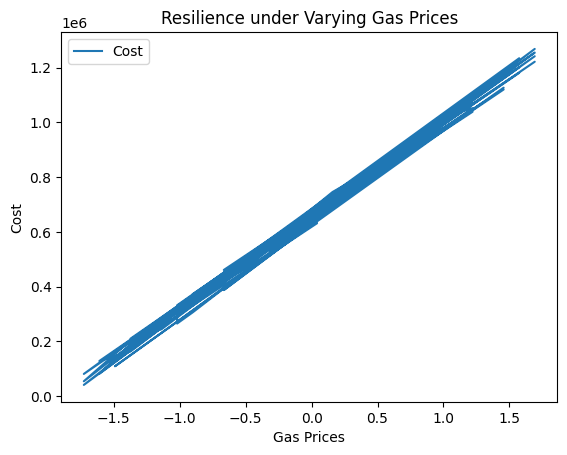

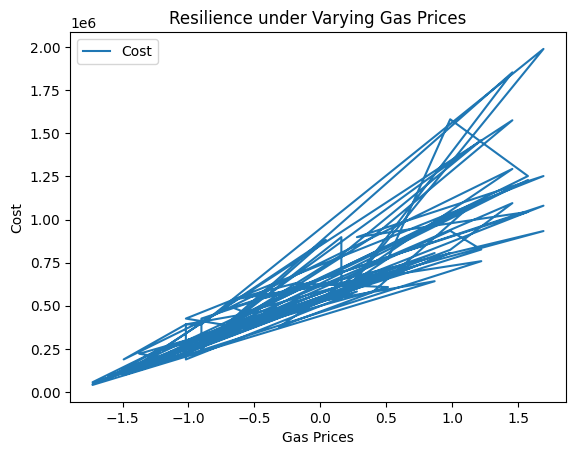

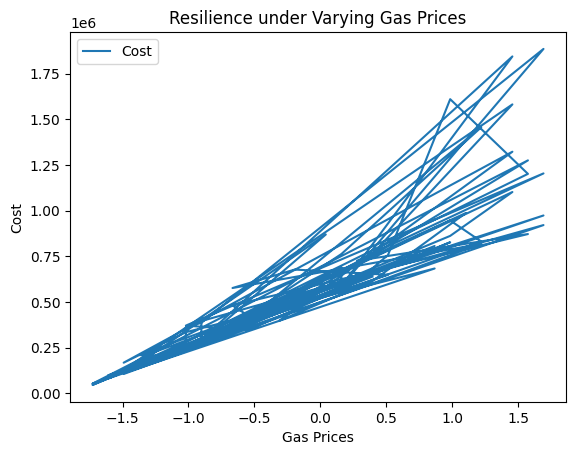

In [9]:
#PLot only gas price against cost 
plot_resilience(lr_test_pred, X_test[:,1])
plot_resilience(dt_test_pred, X_test[:,1])
plot_resilience(rf_test_pred, X_test[:,1])


# Visualizing Results in 3D

First, we define a few functions to visualise the results against both gas price and month. Next, we will apply them on the results from all three ML models.

In [15]:
#Start by putting the results in the right format for plotting.
#Create data frame to plot results

def prepare_plot_data(test_pred, X_test, scaler):
    """
    Transforms scaled predictions and features back to their original scale for visualization.
    
    Parameters:
        lr_test_pred (array-like): Predicted values from the model.
        X_test (array-like): Test feature data, scaled.
        scaler (StandardScaler): The scaler object used to scale the original data.

    Returns:
        pd.DataFrame: A DataFrame containing 'Cost', 'Month', and 'Gas_Price' on their original scales.
    """
    # Extract the mean and std from the scaler
    original_mean = scaler.mean_
    original_std = scaler.scale_

    # Create a DataFrame for visualization
    plot_data = pd.DataFrame({
        "Cost": test_pred,
        "Month": X_test[:, 0],
        "Gas_Price": X_test[:, 1],
    })

    # Reverse scaling for 'Month'
    month_mean = original_mean[0]
    month_std = original_std[0]
    plot_data['Month'] = (plot_data['Month'] * month_std) + month_mean
    plot_data['Month'] = plot_data['Month'].round().astype(int)

    # Reverse scaling for 'Gas_Price'
    gas_price_mean = original_mean[1]
    gas_price_std = original_std[1]
    plot_data['Gas_Price'] = (plot_data['Gas_Price'] * gas_price_std) + gas_price_mean
    plot_data['Gas_Price'] = plot_data['Gas_Price'].round().astype(int)

    return plot_data


In [16]:
#Function to create a scatterplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(gas_price, month, cost, title="3D Scatter Plot of Gas Price, Month, and Cost"):
    """
    Plots a 3D scatter plot of Gas Price, Month, and Cost.
    
    Parameters:
        gas_price (array-like): Values for the x-axis (Gas Price).
        month (array-like): Values for the y-axis (Month).
        cost (array-like): Values for the z-axis and color intensity (Cost).
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(gas_price, month, cost, c=cost, cmap='viridis', marker='o')
    ax.set_xlabel('Gas Price')
    ax.set_ylabel('Month')
    ax.set_zlabel('Cost')
    ax.set_title(title)
    
    # Add color bar for the 'cost' dimension
    colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    colorbar.set_label('Cost')
    
    plt.show()



In [17]:
#Function to create a heatmap

import seaborn as sns

def plot_heatmap(data, index_col, columns_col, values_col, title="Heatmap", figsize=(12, 8), cmap="YlGnBu"):
    """
    Plots a heatmap from a DataFrame by pivoting the specified columns.

    Parameters:
        data (pd.DataFrame): The input DataFrame.
        index_col (str): The column to use as the index for pivoting (e.g., 'Month').
        columns_col (str): The column to use as the columns for pivoting (e.g., 'Gas_Price').
        values_col (str): The column to use as values for the heatmap (e.g., 'Cost').
        title (str): Title of the heatmap.
        figsize (tuple): Size of the figure (width, height).
        cmap (str): Color map to use for the heatmap.
    """
    # Drop duplicate combinations of the specified columns
    unique_data = data.drop_duplicates(subset=[index_col, columns_col])
    
    # Pivot the unique data
    pivot_data = unique_data.pivot(index=index_col, columns=columns_col, values=values_col)
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_data, annot=False, cmap=cmap)
    plt.title(title)
    plt.xlabel(columns_col)
    plt.ylabel(index_col)
    plt.show()


In [24]:
#Function to create a regular plot of gas price vs cost, but plotted for each month

def plot_cost_vs_gas_price(X_test, lr_test_pred, original_mean, original_std, figsize=(10, 6)):
    """
    Plots 'Cost vs Gas Price' for each month after reversing the scaling of months and gas prices.

    Parameters:
        X_test (array-like): Scaled test features, with columns for 'Month' and 'Gas_Price'.
        lr_test_pred (array-like): Predicted values (e.g., costs) from the model.
        original_mean (list or array-like): Original means used during scaling, in the same order as features.
        original_std (list or array-like): Original standard deviations used during scaling, in the same order as features.
        figsize (tuple): Size of the figure (width, height).
    """
    # Create a DataFrame for visualization
    data = pd.DataFrame({
        "Gas_Price": X_test[:, 1],
        "Month": X_test[:, 0],
        "Cost": lr_test_pred,
    })

    # Reverse scaling for months
    data['Month'] = (data['Month'] * original_std[0]) + original_mean[0]
    data['Month'] = data['Month'].round().astype(int)

    # Reverse scaling for gas prices
    data['Gas_Price'] = (data['Gas_Price'] * original_std[1]) + original_mean[1]

    # Plot the data
    plt.figure(figsize=figsize)

    # Iterate over each month and plot a line
    for month in range(1, 13):  # Months 1 to 12
        month_data = data[data['Month'] == month]
        plt.plot(
            month_data['Gas_Price'],
            month_data['Cost'],
            marker='o',
            label=f'Month: {month}'
        )

    # Customize the plot
    plt.xlabel('Gas Price (Original Scale)')
    plt.ylabel('Cost')
    plt.title('Cost vs Gas Price for Each Month')
    plt.legend(title='Month', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Visualising Results

In [20]:
#Prepare data frames to plot the results
plot_lr = prepare_plot_data(lr_test_pred, X_test, calliope_scaler)
plot_dt = prepare_plot_data(dt_test_pred, X_test, calliope_scaler)
plot_rf = prepare_plot_data(rf_test_pred, X_test, calliope_scaler)

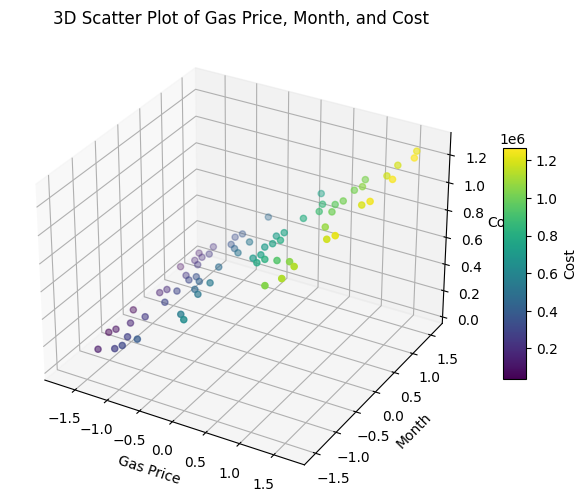

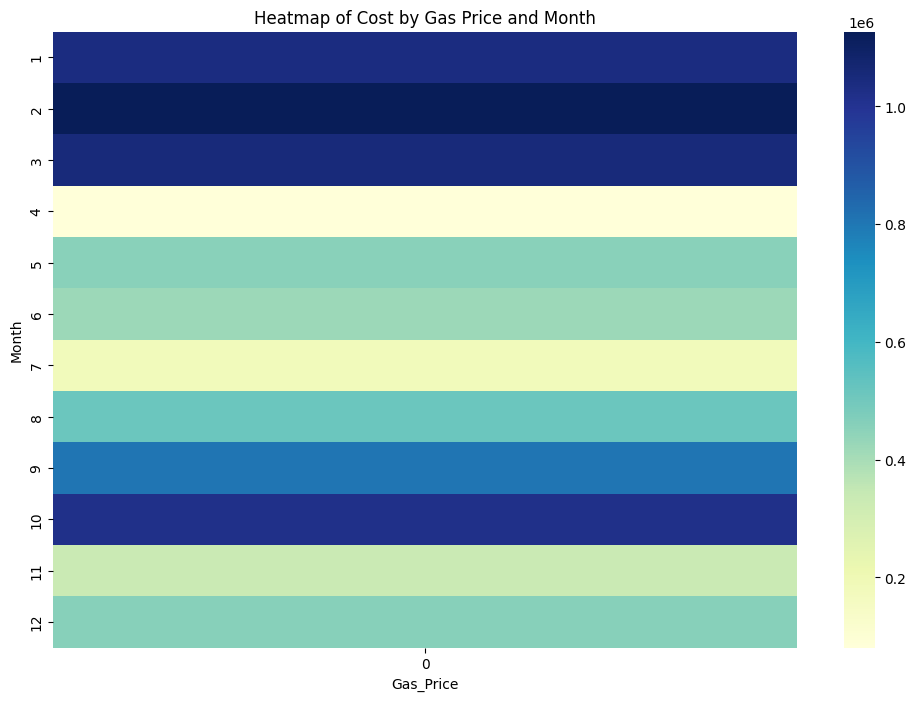

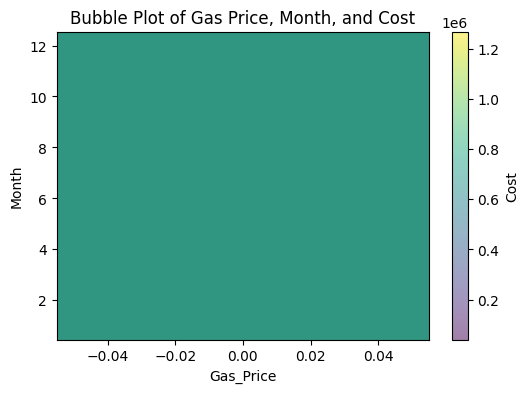

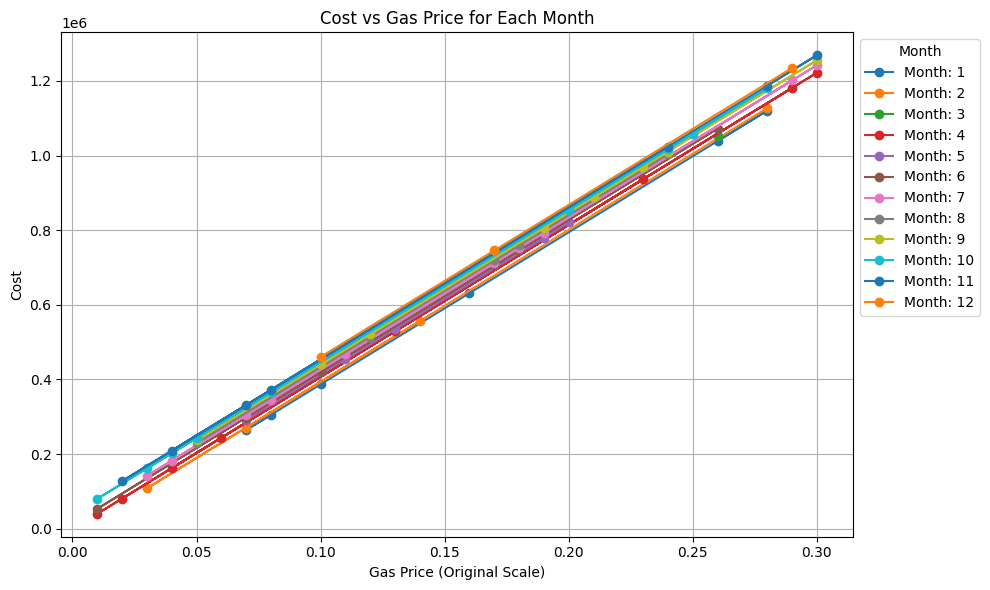

In [26]:
# Linear Regression Model Results
plot_3d_scatter(X_test[:,1], X_test[:,0], lr_test_pred)
plot_heatmap(plot_lr, index_col='Month', columns_col='Gas_Price', values_col='Cost', title='Heatmap of Cost by Gas Price and Month')
plot_cost_vs_gas_price(X_test, lr_test_pred, calliope_scaler.mean_, calliope_scaler.scale_)

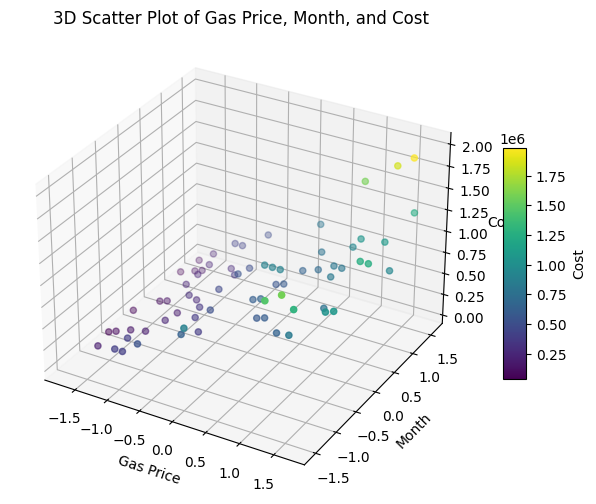

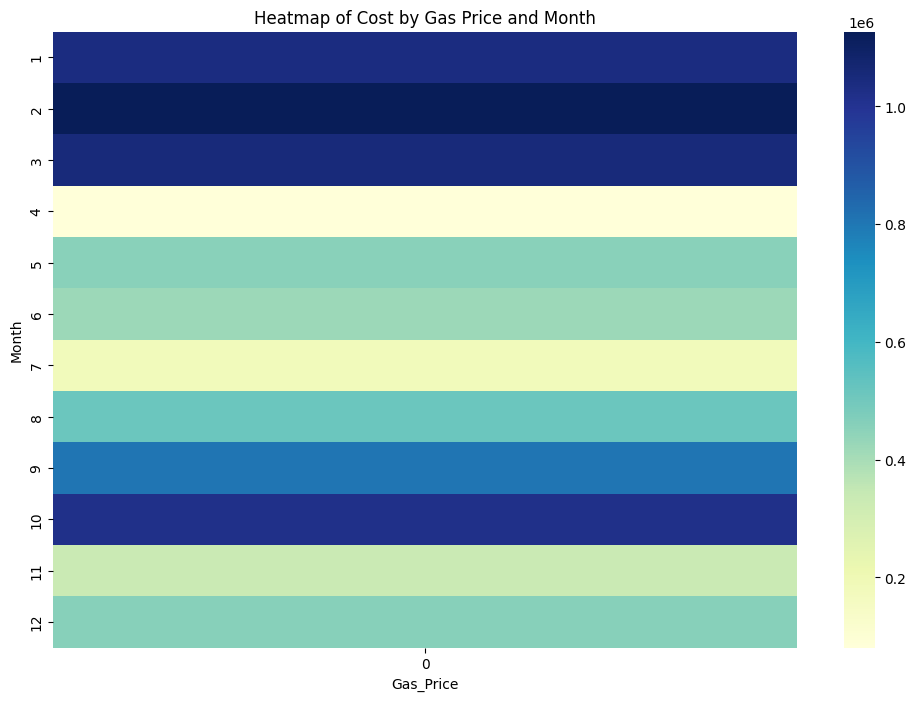

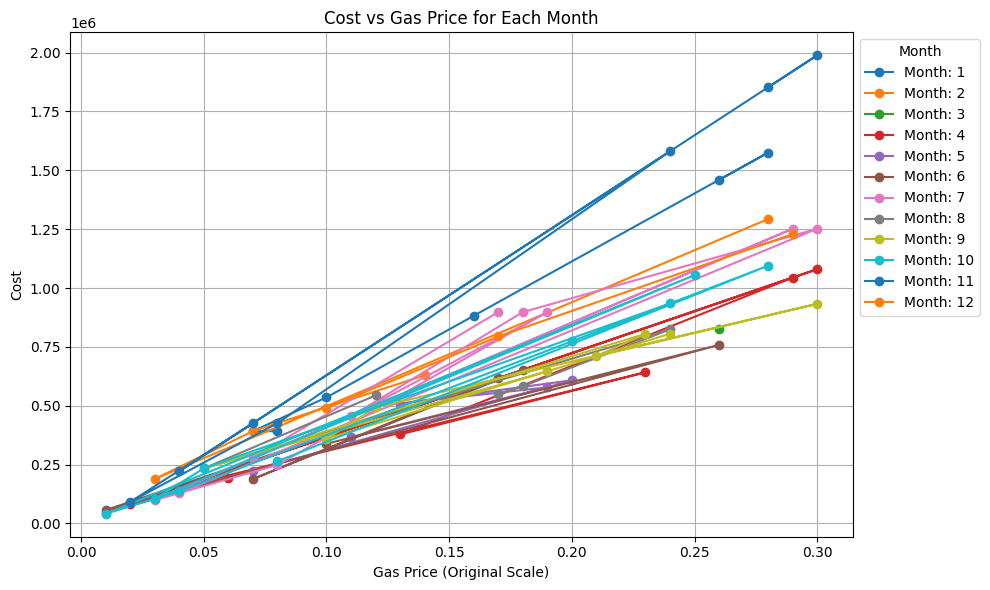

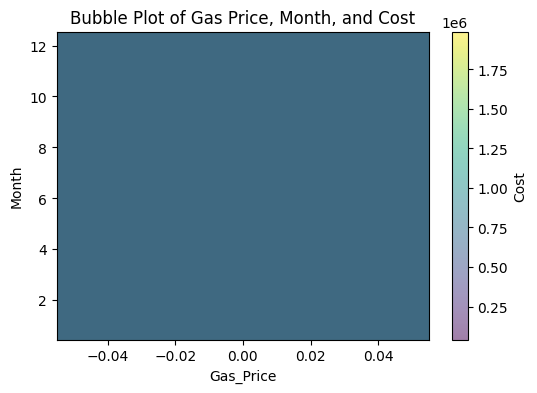

In [28]:
# Decision Tree Model Results
plot_3d_scatter(X_test[:,1], X_test[:,0], dt_test_pred)
plot_heatmap(plot_lr, index_col='Month', columns_col='Gas_Price', values_col='Cost', title='Heatmap of Cost by Gas Price and Month')
plot_cost_vs_gas_price(X_test, dt_test_pred, calliope_scaler.mean_, calliope_scaler.scale_)


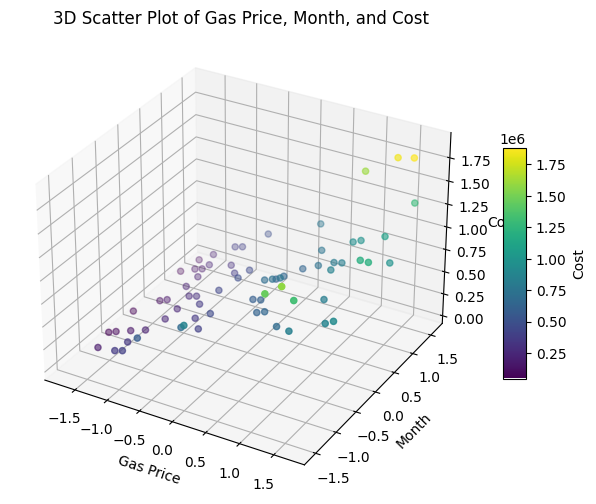

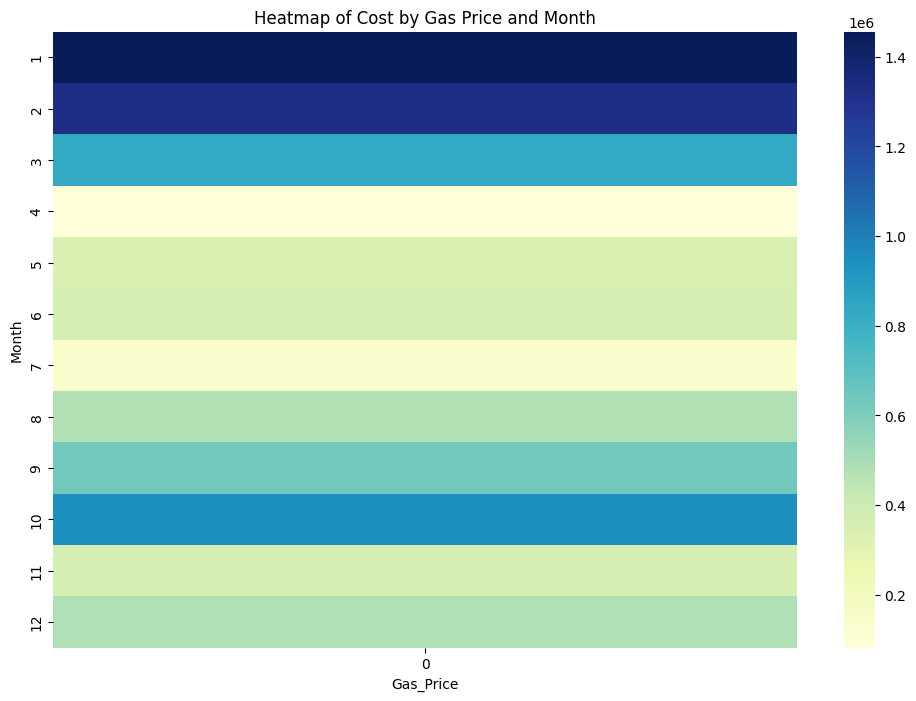

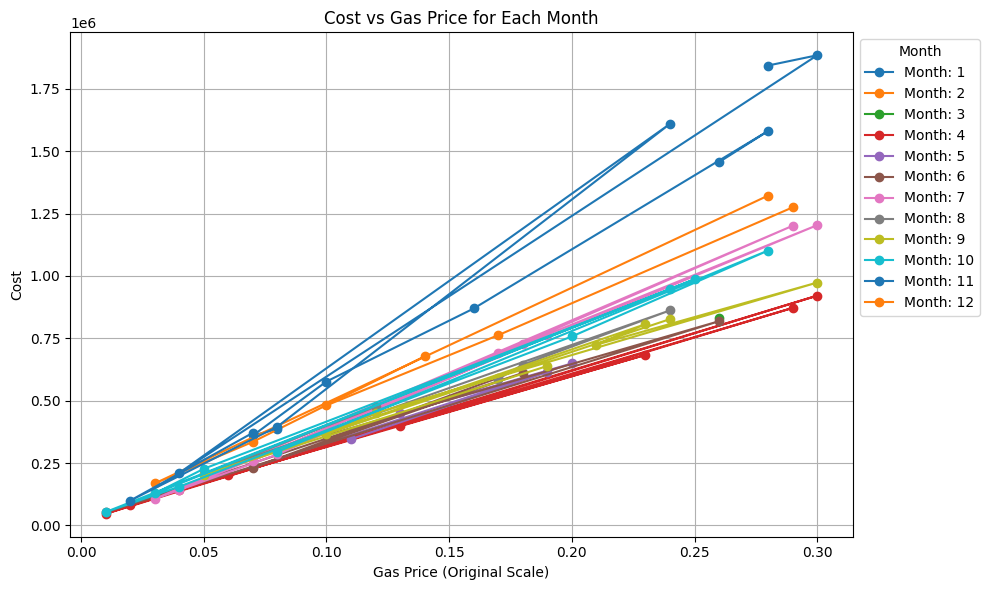

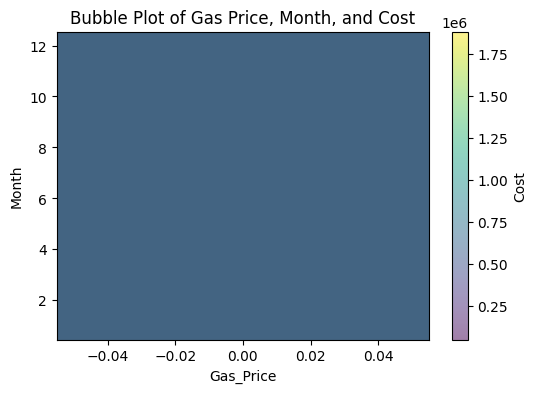

In [27]:
# Random Forest Model Results
plot_3d_scatter(X_test[:,1], X_test[:,0], rf_test_pred)
plot_heatmap(plot_rf, index_col='Month', columns_col='Gas_Price', values_col='Cost', title='Heatmap of Cost by Gas Price and Month')
plot_cost_vs_gas_price(X_test, rf_test_pred, calliope_scaler.mean_, calliope_scaler.scale_)